# Определение числа на изображении

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
RANDOM_STATE = 42

In [80]:
!pip freeze > requirements.txt

## Чтение данных

In [8]:
data = pd.read_csv('images.csv')

In [9]:
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
data['label'].value_counts().sort_index()

0    4132
1    4684
2    4177
3    4351
4    4072
5    3795
6    4137
7    4401
8    4063
9    4188
Name: label, dtype: int64

## Подготовка факторов

In [11]:
y = data['label']
X = data.drop(columns='label')

<Axes: >

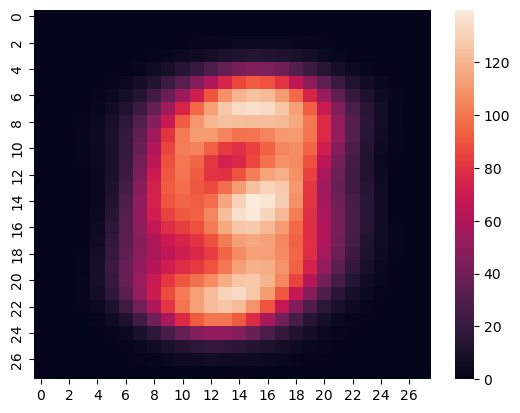

In [12]:
sns.heatmap(pd.DataFrame(X.mean().values.reshape(28,28)))

<Axes: >

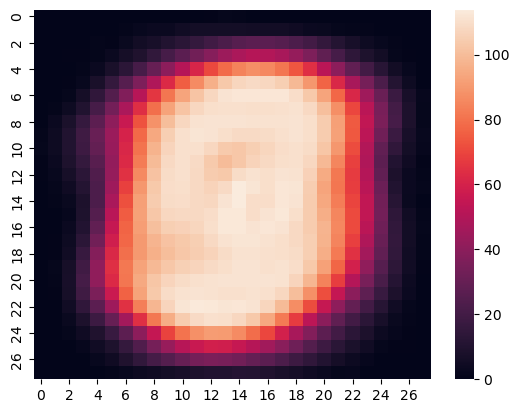

In [13]:
sns.heatmap(pd.DataFrame(X.std().values.reshape(28,28)))

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=RANDOM_STATE)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.25, random_state=RANDOM_STATE)

In [15]:
selector = VarianceThreshold(threshold=0.0)
X_train = pd.DataFrame(selector.fit_transform(X_train))
X_val = pd.DataFrame(selector.transform(X_val))
X_test = pd.DataFrame(selector.transform(X_test))

In [16]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31500 entries, 0 to 31499
Columns: 701 entries, 0 to 700
dtypes: int64(701)
memory usage: 168.5 MB


## Создание модели

### Модель дерева принятия решений

In [38]:
def print_metrics(model, X, y_true):
    y_pred = model.predict(X)
    print(classification_report(y_true, y_pred))
    print("F1 micro score: ", round(f1_score(y_true, y_pred, average='micro'), 3))
    print("F1 macro score: ", round(f1_score(y_true, y_pred, average='macro'), 3))

def print_confusion_matrix(model, X, y_true):
    y_pred = model.predict(X)
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot= True, fmt= 'd', cmap= 'Greens_r')
    plt.ylabel('True values')
    plt.xlabel('Gueeses')
    plt.title('Confusion matrix')

In [66]:
model_1 = DecisionTreeClassifier(criterion='gini', 
                               splitter='best', 
                               max_depth=None,
                               min_samples_leaf = 1, 
                               random_state=RANDOM_STATE,
                              )
model_1.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


**Посмотрим, как модель обучилась на тренировочных данных**

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3107
           1       1.00      1.00      1.00      3538
           2       1.00      1.00      1.00      3105
           3       1.00      1.00      1.00      3200
           4       1.00      1.00      1.00      3048
           5       1.00      1.00      1.00      2897
           6       1.00      1.00      1.00      3127
           7       1.00      1.00      1.00      3266
           8       1.00      1.00      1.00      3058
           9       1.00      1.00      1.00      3154

    accuracy                           1.00     31500
   macro avg       1.00      1.00      1.00     31500
weighted avg       1.00      1.00      1.00     31500

F1 micro score:  1.0
F1 macro score:  1.0


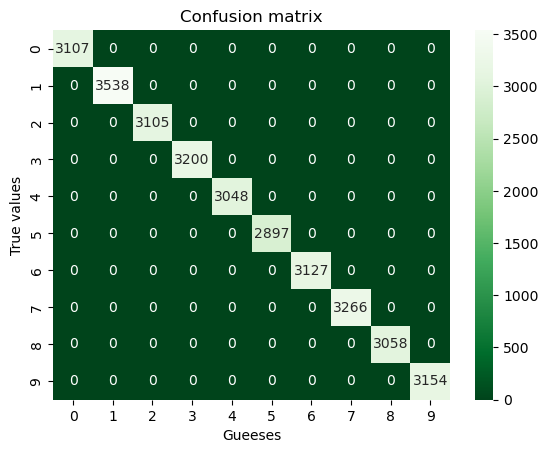

In [53]:
print_metrics(model_1, X_train, y_train)
print_confusion_matrix(model_1, X_train, y_train)

              precision    recall  f1-score   support

           0       0.91      0.91      0.91      1025
           1       0.93      0.95      0.94      1146
           2       0.83      0.83      0.83      1072
           3       0.82      0.80      0.81      1151
           4       0.83      0.86      0.84      1024
           5       0.78      0.79      0.79       898
           6       0.90      0.89      0.89      1010
           7       0.89      0.88      0.88      1135
           8       0.79      0.77      0.78      1005
           9       0.81      0.82      0.81      1034

    accuracy                           0.85     10500
   macro avg       0.85      0.85      0.85     10500
weighted avg       0.85      0.85      0.85     10500

F1 micro score:  0.851
F1 macro score:  0.849


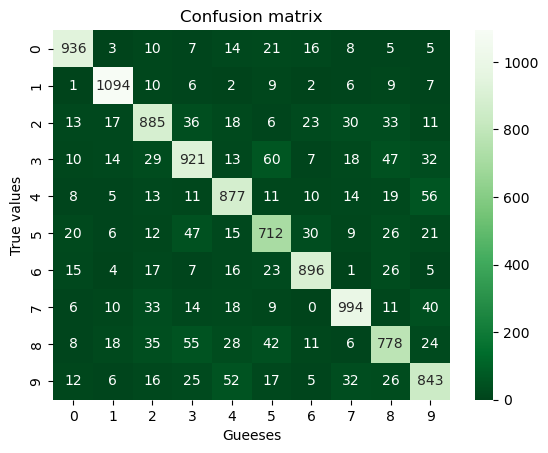

In [54]:
print_metrics(model_1, X_val, y_val)
print_confusion_matrix(model_1, X_val, y_val)

### Подбор гиперпараметров для дерева решений

In [61]:
criterions = ['gini', 'entropy', 'log_loss']
splitters = ['best', 'random']

In [64]:
hyper_matrix = []
for i in criterions:
    temp = []
    for j in splitters:
        model_temp = DecisionTreeClassifier(criterion=i, 
                               splitter=j, 
                               max_depth=None,
                               min_samples_leaf = 1, 
                               random_state=RANDOM_STATE,
                              )
        model_temp.fit(X_train, y_train)
        y_hyper_pred = model_temp.predict(X_val)
        temp.append(round(f1_score(y_val, y_hyper_pred, average='macro'), 3))
    hyper_matrix.append(temp)
hyper_matrix = pd.DataFrame(hyper_matrix, index=criterions, columns=splitters)
hyper_matrix

,best,random
gini,0.849,0.851
entropy,0.859,0.859
log_loss,0.859,0.859


**Заметим, что параметры 'gini' и 'best' дают худший результат на валидационной выборке. Возьмем 'entropy' и 'best' и переобучим модель**

In [67]:
model_1_new = DecisionTreeClassifier(criterion='entropy', 
                               splitter='best', 
                               max_depth=None,
                               min_samples_leaf = 1, 
                               random_state=RANDOM_STATE,
                              )
model_1_new.fit(X_train, y_train)

,criterion,'entropy'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


              precision    recall  f1-score   support

           0       0.91      0.91      0.91       816
           1       0.93      0.96      0.94       909
           2       0.83      0.82      0.83       846
           3       0.82      0.80      0.81       937
           4       0.83      0.85      0.84       839
           5       0.78      0.78      0.78       702
           6       0.89      0.88      0.89       785
           7       0.88      0.88      0.88       893
           8       0.79      0.77      0.78       835
           9       0.82      0.82      0.82       838

    accuracy                           0.85      8400
   macro avg       0.85      0.85      0.85      8400
weighted avg       0.85      0.85      0.85      8400

F1 micro score:  0.85
F1 macro score:  0.849
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       816
           1       0.94      0.96      0.95       909
           2       0.86      0.84

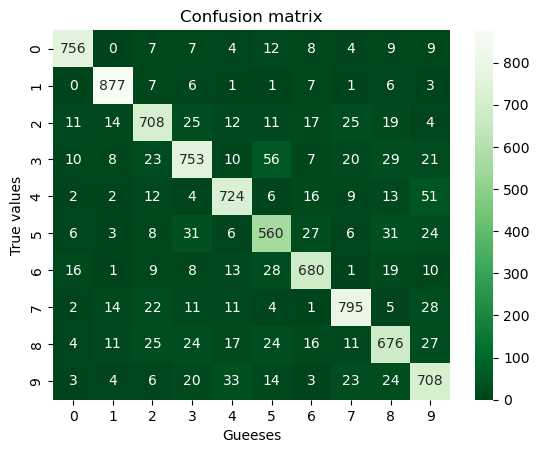

In [70]:
print_metrics(model_1, X_test, y_test)
print_metrics(model_1_new, X_test, y_test)
print_confusion_matrix(model_1_new, X_test, y_test)

**Можно заметить, что выбор гиперпараметров на валидационной выборке повысил качество модели**

### Модель случайного леса

In [44]:
model_rand_forest = RandomForestClassifier(n_estimators=100, 
                                          criterion='gini',
                                          max_depth=None,
                                          min_samples_leaf=1,
                                          max_features='sqrt',
                                          bootstrap=True,
                                          random_state=RANDOM_STATE,
                                          )
model_rand_forest.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3107
           1       1.00      1.00      1.00      3538
           2       1.00      1.00      1.00      3105
           3       1.00      1.00      1.00      3200
           4       1.00      1.00      1.00      3048
           5       1.00      1.00      1.00      2897
           6       1.00      1.00      1.00      3127
           7       1.00      1.00      1.00      3266
           8       1.00      1.00      1.00      3058
           9       1.00      1.00      1.00      3154

    accuracy                           1.00     31500
   macro avg       1.00      1.00      1.00     31500
weighted avg       1.00      1.00      1.00     31500

F1 micro score:  1.0
F1 macro score:  1.0


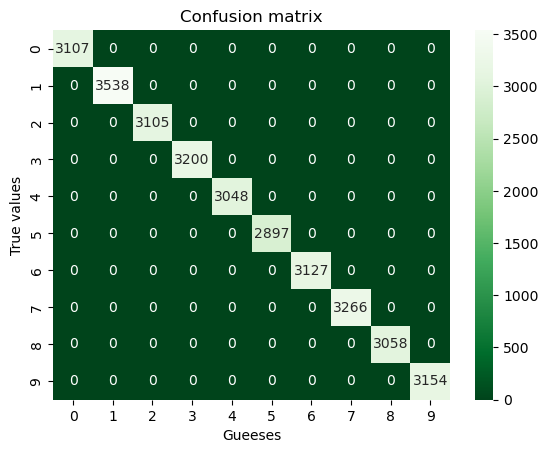

In [45]:
print_metrics(model_rand_forest, X_train, y_train)
print_confusion_matrix(model_rand_forest, X_train, y_train)

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1025
           1       0.98      0.99      0.99      1146
           2       0.96      0.96      0.96      1072
           3       0.96      0.94      0.95      1151
           4       0.96      0.97      0.97      1024
           5       0.96      0.96      0.96       898
           6       0.97      0.98      0.97      1010
           7       0.97      0.95      0.96      1135
           8       0.96      0.95      0.95      1005
           9       0.93      0.94      0.94      1034

    accuracy                           0.96     10500
   macro avg       0.96      0.96      0.96     10500
weighted avg       0.96      0.96      0.96     10500

F1 micro score:  0.963
F1 macro score:  0.963


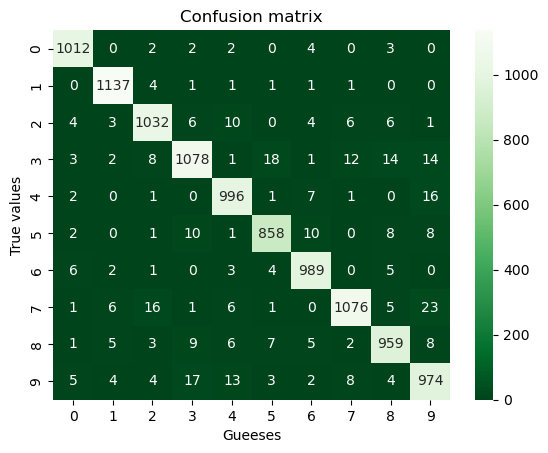

In [46]:
print_metrics(model_rand_forest, X_val, y_val)
print_confusion_matrix(model_rand_forest, X_val, y_val)

### Подбор гиперпараметров модели случайного леса

In [72]:
max_features = ['sqrt', 'log2', 0.5, 0.1]
n_estimators = [i for i in range(100, 160, 10)]

In [73]:
hyper_matrix_random_forest = []
for i in max_features:
    temp = []
    for j in n_estimators:
        model_rand_forest_temp = RandomForestClassifier(n_estimators=j, 
                                          criterion='gini',
                                          max_depth=None,
                                          min_samples_leaf=1,
                                          max_features=i,
                                          bootstrap=True,
                                          random_state=RANDOM_STATE,
                                          )
        model_rand_forest_temp.fit(X_train, y_train)
        
        y_hyper_forest_pred = model_temp.predict(X_val)
        temp.append(round(f1_score(y_val, y_hyper_forest_pred, average='macro'), 3))
        
    hyper_matrix_random_forest.append(temp)
    
hyper_matrix_random_forest = pd.DataFrame(hyper_matrix_random_forest, index=max_features, columns=n_estimators)
hyper_matrix_random_forest

,100,110,120,130,140,150
sqrt,0.859,0.859,0.859,0.859,0.859,0.859
log2,0.859,0.859,0.859,0.859,0.859,0.859
0.5,0.859,0.859,0.859,0.859,0.859,0.859
0.1,0.859,0.859,0.859,0.859,0.859,0.859


**Видно, что на всех гиперпараметрах модель ведет себя хуже, чем на изначальных -> их и оставим для финальной модели**

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       816
           1       0.98      0.99      0.99       909
           2       0.96      0.96      0.96       846
           3       0.96      0.93      0.94       937
           4       0.95      0.97      0.96       839
           5       0.96      0.95      0.96       702
           6       0.97      0.98      0.98       785
           7       0.97      0.95      0.96       893
           8       0.95      0.95      0.95       835
           9       0.93      0.94      0.94       838

    accuracy                           0.96      8400
   macro avg       0.96      0.96      0.96      8400
weighted avg       0.96      0.96      0.96      8400

F1 micro score:  0.961
F1 macro score:  0.961


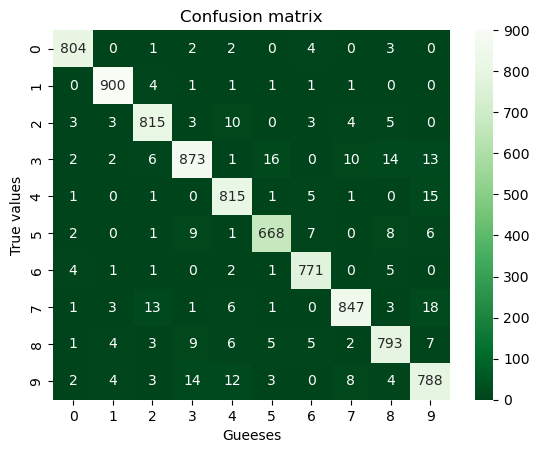

In [60]:
print_metrics(model_rand_forest, X_test, y_test)
print_confusion_matrix(model_rand_forest, X_test, y_test)

### Метрики для моделей на тестовой выборке с доверительными интервалами

In [79]:
def bootstrap_indices(n, rng):
    return rng.choice(n, size=n, replace=True)

def bootstrap_indices_stratified(y, rng):
    y = np.asarray(y)
    idxs = np.arange(len(y))
    out = np.empty_like(idxs)
    pos = 0
    for cls in np.unique(y):
        cls_idx = idxs[y == cls]
        k = len(cls_idx)
        out[pos:pos+k] = rng.choice(cls_idx, size=k, replace=True)
        pos += k
    return out

def bootstrap_ci_for_labels(
    y_true,
    y_pred,
    metric_fn,
    n_boot: int = 5000,
    alpha: float = 0.05,
    stratified: bool = False,
    random_state: int = RANDOM_STATE,
    return_distribution: bool = False,
):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    n = y_true.shape[0]

    rng = np.random.default_rng(random_state)
    vals = np.empty(n_boot, dtype=float)

    for b in range(n_boot):
        idx = (bootstrap_indices_stratified(y_true, rng)
               if stratified else
               bootstrap_indices(n, rng))
        vals[b] = metric_fn(y_true[idx], y_pred[idx])

    lo = np.percentile(vals, 100 * (alpha / 2))
    hi = np.percentile(vals, 100 * (1 - alpha / 2))
    if return_distribution:
        return vals.mean(), (lo, hi), vals
    return vals.mean(), (lo, hi)

In [78]:
yt_pred = model_1_new.predict(X_test)
yf_pred = model_rand_forest.predict(X_test)
acc_tree = bootstrap_ci_for_labels(y_test, yt_pred,
                                   metric_fn=accuracy_score,
                                   n_boot=5000, stratified=True, random_state=RANDOM_STATE)

f1_tree  = bootstrap_ci_for_labels(y_test, yt_pred,
                                   metric_fn=lambda yt, yp: f1_score(yt, yp, average="macro"),
                                   n_boot=5000, stratified=True, random_state=RANDOM_STATE)

acc_rf = bootstrap_ci_for_labels(y_test, yf_pred,
                                 metric_fn=accuracy_score,
                                 n_boot=5000, stratified=True, random_state=RANDOM_STATE)

f1_rf  = bootstrap_ci_for_labels(y_test, yf_pred,
                                 metric_fn=lambda yt, yp: f1_score(yt, yp, average="macro"),
                                 n_boot=5000, stratified=True, random_state=RANDOM_STATE)

print(f"Tree:    acc mean={acc_tree[0]:.4f}, 95% CI=({acc_tree[1][0]:.4f}, {acc_tree[1][1]:.4f})")
print(f"Tree:    f1  mean={f1_tree[0]:.4f}, 95% CI=({f1_tree[1][0]:.4f}, {f1_tree[1][1]:.4f})")
print(f"Forest:  acc mean={acc_rf[0]:.4f}, 95% CI=({acc_rf[1][0]:.4f}, {acc_rf[1][1]:.4f})")
print(f"Forest:  f1  mean={f1_rf[0]:.4f}, 95% CI=({f1_rf[1][0]:.4f}, {f1_rf[1][1]:.4f})")


Tree:    acc mean=0.8615, 95% CI=(0.8543, 0.8687)
Tree:    f1  mean=0.8600, 95% CI=(0.8527, 0.8669)
Forest:  acc mean=0.9612, 95% CI=(0.9571, 0.9652)
Forest:  f1  mean=0.9612, 95% CI=(0.9570, 0.9653)


## Вывод


Решена задача распознавания рукописных цифр по пиксельным признакам. Предобработка выполнена через `VarianceThreshold`. Сравнены `DecisionTreeClassifier` и `RandomForestClassifier`: дерево переобучается и уступает на тесте (accuracy и macro-F1 заметно ниже), случайный лес даёт устойчиво высокие результаты на тестовой выборке и превосходит дерево. Неопределённость оценена бутстрапом по тесту (percentile CI) без дообучения на бутстрап-подвыборках; интервалы подтверждают преимущество случайного леса.
